## Preučimo podatke o COVID-u

Podatkovno rudarjenje, naloga, `12.4.2022`  

**`Člani: Tomaž Čuk, Tim Kuhar & Jorg Cimperman (Vodja).`**

##### Priprava podatkov
V spodnji celici bomo prebrali ".csv" datoteke in pripravili podatke v pravilni obliki. ".csv" datoteke smo pridobili s strani:
https://covid-19.sledilnik.org/sl/stats

In [2]:
import csv
from csv import DictReader
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def read_file(filename):
    arr = []
    reader = DictReader(open(filename, 'rt', encoding='utf-8'))
    for row in reader:
        arr.append(row)
    return arr

stats = read_file('podatki/stats.csv')
for i, day in enumerate(stats[1:]):
    day['cases.recovered'] = int(day['cases.recovered.todate'] or 0) - int(stats[i]['cases.recovered.todate'] or 0)

stats[0]['cases.recovered'] = 0


vaccination = read_file("podatki/vaccination.csv")

region_cases = read_file("podatki/region-cases.csv")

municipality = read_file("podatki/municipality-cases.csv")

from collections import defaultdict
muni = {}

for m in municipality:
    muni_day = {}
    for key in m:
        key_ar = key.split(".", 3)
        if key_ar[-1] == "cases.active":
            if key_ar[1] not in muni_day:
                muni_day[key_ar[1]] = {}
            if key_ar[2] not in muni_day[key_ar[1]]:
                muni_day[key_ar[1]][key_ar[2]] = int(m[key] or 0)
    muni[m["date"]] = muni_day

# slovarji

dict_age_groups = read_file('podatki/slovarji/dict-age-groups.csv')

dict_region = read_file('podatki/slovarji/dict-region.csv')

dict_municipality = read_file('podatki/slovarji/dict-municipality.csv')


# 1.1. vprašanje: Koliko okužb je glede na cepljenost?
<div style="display: flex; align-items: center">
<img src="https://media0.giphy.com/avatars/designerauge/4rLyVYoSfDJ3.gif" alt="drawing" width="100" height="100" style="display: block; margin-right: 10px;"/>

<span style="align:left; text-align:center;"><b>Glavno vprašanje</b>, ki se poraja vsakemu Slovencu je seveda, ali je cepivo učinkovito. Zato smo se odločili, da kot prvo vprašanje postavimo, koliko okužb imamo dnevno glede na (pre)cepljenost.</span>
</div>


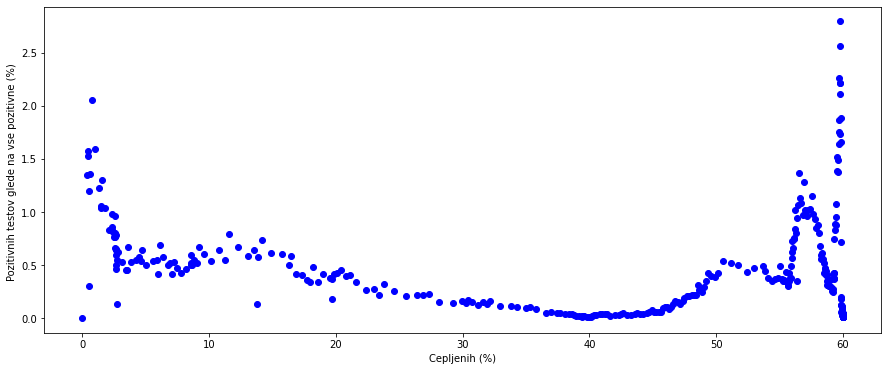

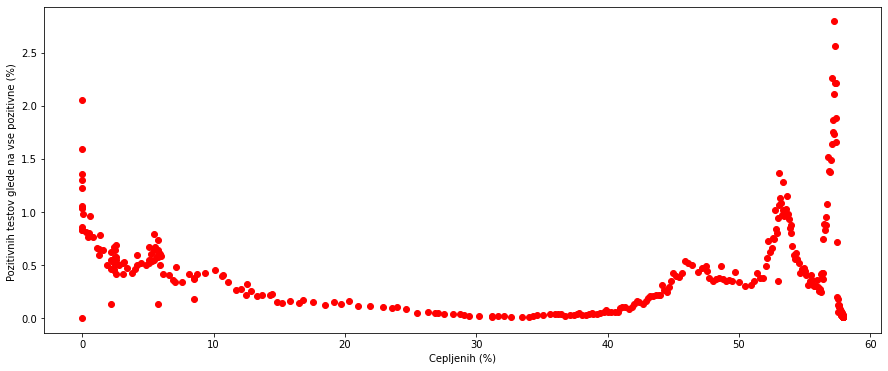

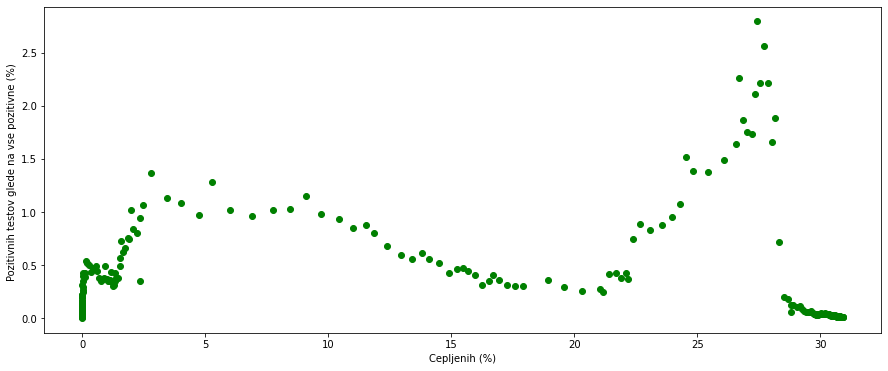

In [3]:
# tabela podatkov, ki jih dopolnimo
data = []

# št prebivalcev slovenije
slo_pop = 2108708

# izračun indeksa v tabeli, ko se je začelo cepljenje z odmerki (1. , 2. , 3.)
first_vaccinated_1 = -1
first_vaccinated_2 = -1
first_vaccinated_3 = -1
i = 0
for day in stats:
    cur_date = datetime.strptime(day["date"], '%Y-%m-%d')
    if cur_date.weekday() >= 5:
        continue

    if first_vaccinated_1 == -1 and (int(day["vaccination.administered.todate"]) if len(day["vaccination.administered.todate"]) else 0) > 0:
        first_vaccinated_1 = i
    if first_vaccinated_2 == -1 and (int(day["vaccination.administered2nd.todate"]) if len(day["vaccination.administered2nd.todate"]) else 0) > 0:
        first_vaccinated_2 = i
    if first_vaccinated_3 == -1 and (int(day["vaccination.administered3rd.todate"]) if len(day["vaccination.administered3rd.todate"]) else 0) > 0:
        first_vaccinated_3 = i
        break

    i += 1

# branje podatkov iz tabel, če je dan med vikendom ga ignoriramo
for day in stats:
    # format: 2020-02-24
    cur_date = datetime.strptime(day["date"], '%Y-%m-%d')
    if cur_date.weekday() >= 5:
        continue
    day_data = {
        "date": day["date"],
        # positive: procent novo pozitivnih glede na že pozitivne
        "positive": (int(day["tests.positive"]) / int(day["tests.positive.todate"])) * 100 if len(day["tests.positive"]) else 0,
        # št vseh cepljenih s 1. odmerkom
        "vaccinated_past_1st": int(day["vaccination.administered.todate"]) if len(day["vaccination.administered.todate"]) else 0,
        # št vseh cepljenih z 2. odmerkom
        "vaccinated_past_2nd": int(day["vaccination.administered2nd.todate"]) if len(day["vaccination.administered2nd.todate"]) else 0,
        # št vseh cepljenih s 3. odmerkom
        "vaccinated_past_3rd": int(day["vaccination.administered3rd.todate"]) if len(day["vaccination.administered3rd.todate"]) else 0
    }
    data.append(day_data)


# dates = [x["date"] for x in data]

# tabela števil pozitivnosti
positive = [x["positive"] for x in data]
# tabela števil pozitivnosti od dneva ko se je prvič začelo cepiti
positive_vac1 = positive[first_vaccinated_1:]
# tabela števil pozitivnosti od dneva ko se je drugič začelo cepiti
positive_vac2 = positive[first_vaccinated_2:]
# tabela števil pozitivnosti od dneva ko se je tretjič začelo cepiti
positive_vac3 = positive[first_vaccinated_3:]
vaccinated_past_1st = [(x["vaccinated_past_1st"] / slo_pop) * 100 for x in data][first_vaccinated_1:]
vaccinated_past_2nd = [(x["vaccinated_past_2nd"] / slo_pop) * 100 for x in data][first_vaccinated_2:]
vaccinated_past_3rd = [(x["vaccinated_past_3rd"] / slo_pop) * 100 for x in data][first_vaccinated_3:]


plt.figure(figsize=(15,6))
plt.xlabel("Cepljenih (%)")
plt.ylabel("Pozitivnih testov glede na vse pozitivne (%) ")
plt.scatter(vaccinated_past_1st,positive_vac1, color="blue")
plt.show()
plt.figure(figsize=(15,6))
plt.xlabel("Cepljenih (%)")
plt.ylabel("Pozitivnih testov glede na vse pozitivne (%) ")
plt.scatter(vaccinated_past_2nd,positive_vac2, color="red")
plt.show()
plt.figure(figsize=(15,6))
plt.xlabel("Cepljenih (%)")
plt.ylabel("Pozitivnih testov glede na vse pozitivne (%) ")
plt.scatter(vaccinated_past_3rd,positive_vac3, color="green")
plt.show()

**ODGOVOR**

<div style="display: flex; align-items: center">
<img src="https://media0.giphy.com/media/gH94kBTHmFum6aMYzu/giphy.gif?cid=ecf05e479ewwdhf3b5fno334ubolhamx30j6pdhwph1wq0b9&rid=giphy.gif&ct=s" alt="drawing" width="100" height="100" style="display: block; margin-right: 10px;"/>

<span style="align:left; text-align:center;">Kot lahko razberemo iz grafov je cepivo pri 1. in 2. odmerku učinkovalo nekaj časa, potem pri zadnjem valu nekaj mesecev nazaj pa ni imelo učinka. Kot vidimo, se oblika grafa ponavlja. Domnevamo, da se z večjo precepljenostjo ljudje razvadijo in ne upoštevajo glavnih preventiv. Tako se okuži več ljudi in zgodi se skok (spike). Nato pa okužbe padejo, saj ljudje začasno postanejo imuni, saj so preboleli ali pa so cepljeni.
</br></br>
Domnevamo, da je morda razlog nova različica Omicron, ki naj bi bila bolj odporna na cepivo.
Pri tretjem odmerku pa ni bilo tako prepoznavnega učinka. Tu pa vemo da 3. odmerek samo podaljša trajanje cepiva in ni toliko različen od 2. odmerka, zato menimo, da so ljudje, ki so že bili cepljeni 2x ostali "imuni" na virus in se tako kot po 2. cepljenju tudi po 3. niso okužili.</span>
</div>

# 1.2. vprašanje: Koliko okužb je glede na oceno zaščitenosti?

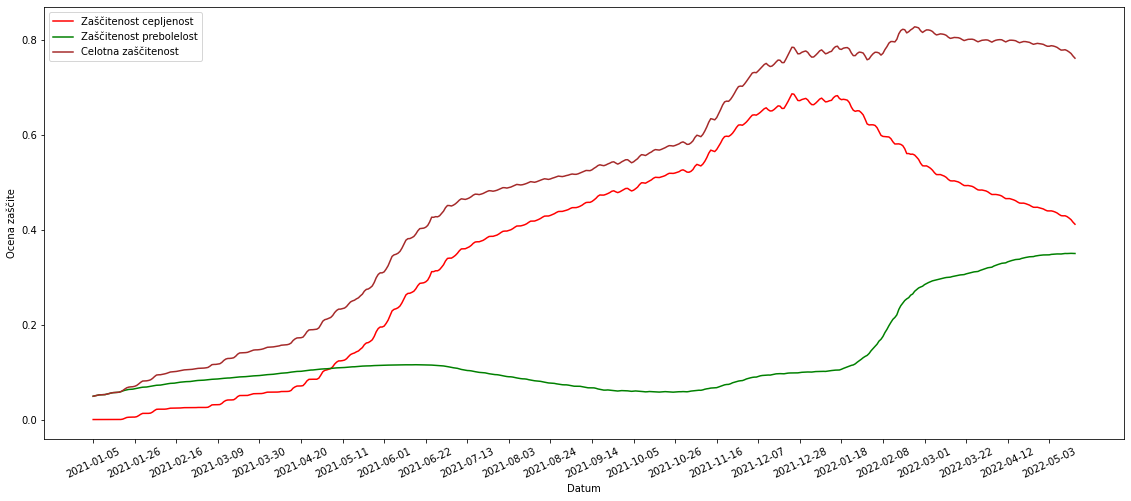

In [4]:
# [1 , 2 ,3 , 4] predstavljajo % protected od celotne populacije# tabela podatkov, ki jih dopolnimo
data = []

# št prebivalcev slovenije
slo_pop = 2108708

# izračun indeksa v tabeli, ko se je začelo cepljenje z odmerki (1. , 2. , 3.)
first_vaccinated_1 = -1
first_vaccinated_2 = -1
first_vaccinated_3 = -1
i = 0
for day in stats:
    cur_date = datetime.strptime(day["date"], '%Y-%m-%d')
    i += 1
    if cur_date.weekday() >= 5:
        continue

    if first_vaccinated_1 == -1 and (int(day["vaccination.administered.todate"]) if len(day["vaccination.administered.todate"]) else 0) > 0:
        first_vaccinated_1 = i
    if first_vaccinated_2 == -1 and (int(day["vaccination.administered2nd.todate"]) if len(day["vaccination.administered2nd.todate"]) else 0) > 0:
        first_vaccinated_2 = i
    if first_vaccinated_3 == -1 and (int(day["vaccination.administered3rd.todate"]) if len(day["vaccination.administered3rd.todate"]) else 0) > 0:
        first_vaccinated_3 = i
        break

protected_vacc = []
protected_reco = []
protected_sum = []
positive = []
dates = []

for i, daily in enumerate(stats[first_vaccinated_2:]):
    index = i + first_vaccinated_2

    sum_vaccinated = 0
    sum_recovered = 0
    sum_vacc_rec = 0

    for stat in stats[max(0, index - 240):index]:
        sum_vaccinated += int(stat["vaccination.administered2nd"] or 0) + int(stat["vaccination.administered3rd"] or 0)
        sum_recovered += int(stat['cases.recovered'])
        sum_vacc_rec += int(stat["vaccination.administered2nd"] or 0) + int(stat["vaccination.administered3rd"] or 0) + int(stat['cases.recovered'])

    protected_vacc_percentage = sum_vaccinated / slo_pop
    protected_vacc.append(protected_vacc_percentage)

    protected_rec_percentage = sum_recovered / slo_pop
    protected_reco.append(protected_rec_percentage)

    protected_percentage = sum_vacc_rec / slo_pop
    protected_sum.append(protected_percentage)

    dates.append(daily["date"])
    positive.append(int(daily["tests.positive"]) / int(daily["tests.positive.todate"]) * 100 if len(daily["tests.positive"]) else 0)

new_dates = []
new_dates_index = []

for i, d in enumerate(dates):
    if i % 21 == 0:
        new_dates.append(d)
        new_dates_index.append(i)


fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(protected_vacc, color="red", label="Zaščitenost cepljenost")
ax.plot(protected_reco, color="green", label="Zaščitenost prebolelost")
ax.plot(protected_sum, color="brown", label="Celotna zaščitenost")
ax.set_xticks(new_dates_index)
ax.set_xticklabels(new_dates)
plt.ylabel("Ocena zaščite")
plt.xlabel("Datum")
plt.xticks(rotation = 25)
plt.legend()
plt.show()


# Vprašanje 2: Osebe v bolnišnici

In [5]:
positive = []
in_hospital = []
icu = []
critical = []
dates = []

for day in stats:
    # format: 2020-02-24
    cur_date = datetime.strptime(day["date"], '%Y-%m-%d')
    if cur_date.weekday() >= 5:
        continue

    dates.append(day["date"])
    positive.append(int(day["tests.positive"]) if len(day["tests.positive"]) else 0)
    in_hospital.append(int(day["state.in_hospital"]) if len(day["state.in_hospital"]) else 0)
    icu.append(int(day["state.icu"]) if len(day["state.icu"]) else 0)
    critical.append(int(day["state.critical"]) if len(day["state.critical"]) else 0)


    # v bolnisnici, intenzivni negi, v kriticnem stanju
    # state.in_hospital, state.icu, state.critical

# Make every n index in array not empty
new_dates = []
new_dates_index = []

for i, d in enumerate(dates):
    if i % 21 == 0:
        new_dates.append(d)
        new_dates_index.append(i)

## 2.1 Koliko oseb je v bolnišnici glede na število okužb?

<div style="display: flex; align-items: center">
<img src="https://media4.giphy.com/media/feP0faKTehLA93yhFU/giphy.gif?cid=790b76117e13f9ed6a477a2bff16cbdf4e4360d21aa0edaf&rid=giphy.gif&ct=s" alt="drawing" width="100" height="100" style="display: block; margin-right: 10px;"/>

<span style="align:left; text-align:center;">Zanimalo nas je tudi, koliko oseb pravzaprav pristane na intenzivni negi z večanjem okužb. Seveda vemo, da se bo ta številka večala, vendar v kakšni meri se to dogaja?</span>
</div>

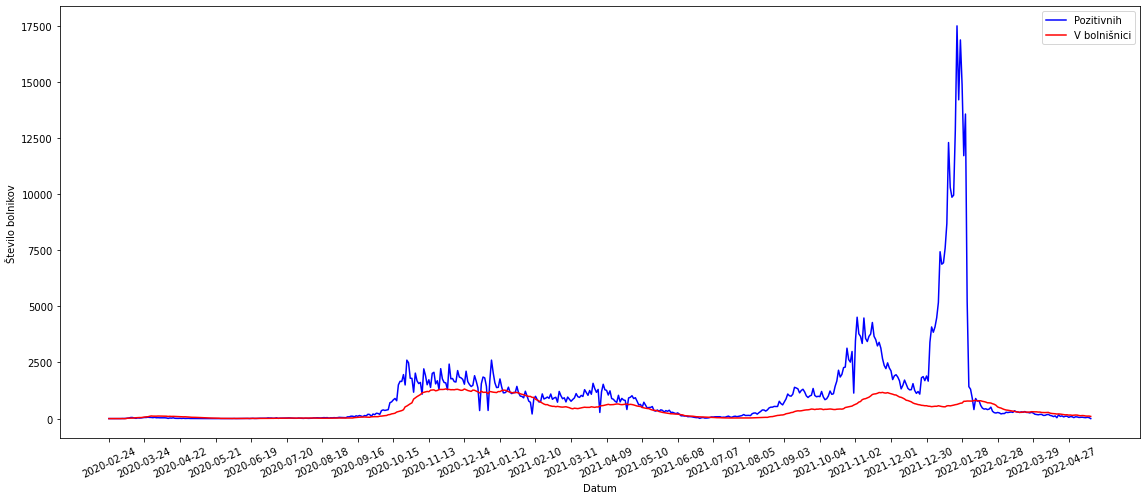

In [6]:


fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(positive, color="blue", label="Pozitivnih")
ax.plot(in_hospital, color="red", label="V bolnišnici")
ax.set_xticks(new_dates_index)
ax.set_xticklabels(new_dates)
plt.ylabel("Število bolnikov")
plt.xlabel("Datum")
plt.xticks(rotation = 25)
plt.legend()
plt.show()

**ODGOVOR**

<div style="display: flex; align-items: center">
<img src="https://media0.giphy.com/media/gH94kBTHmFum6aMYzu/giphy.gif?cid=ecf05e479ewwdhf3b5fno334ubolhamx30j6pdhwph1wq0b9&rid=giphy.gif&ct=s" alt="drawing" width="100" height="100" style="display: block; margin-right: 10px;"/>

<span style="align:left; text-align:center;">Kot lahko opazimo iz grafa, število hospitaliziranih oseb narašča kadar naraščajo okužbe, vendar v zadnjem valu lahko vidimo, da število hospitaliziranih oseb ni tako zelo veliko v primerjavi s številom okužb, saj je bila najbolj razširjena različica Omicron, ki ni tako močna, pravtako pa je bilo že veliko ljudi cepljenih.</span>
</div>

## 2.2 Koliko jih je v intenzivni glede na hospitalizirane osebe?

<div style="display: flex; align-items: center">
<img src="https://media4.giphy.com/media/feP0faKTehLA93yhFU/giphy.gif?cid=790b76117e13f9ed6a477a2bff16cbdf4e4360d21aa0edaf&rid=giphy.gif&ct=s" alt="drawing" width="100" height="100" style="display: block; margin-right: 10px;"/>

<span style="align:left; text-align:center;">Naslednje kar nas je zanimalo pa je bilo, koliko od hospitaliziranih oseb je pravzaprav na intenzivni negi oz. v kritičnem stanju.</span>
</div>

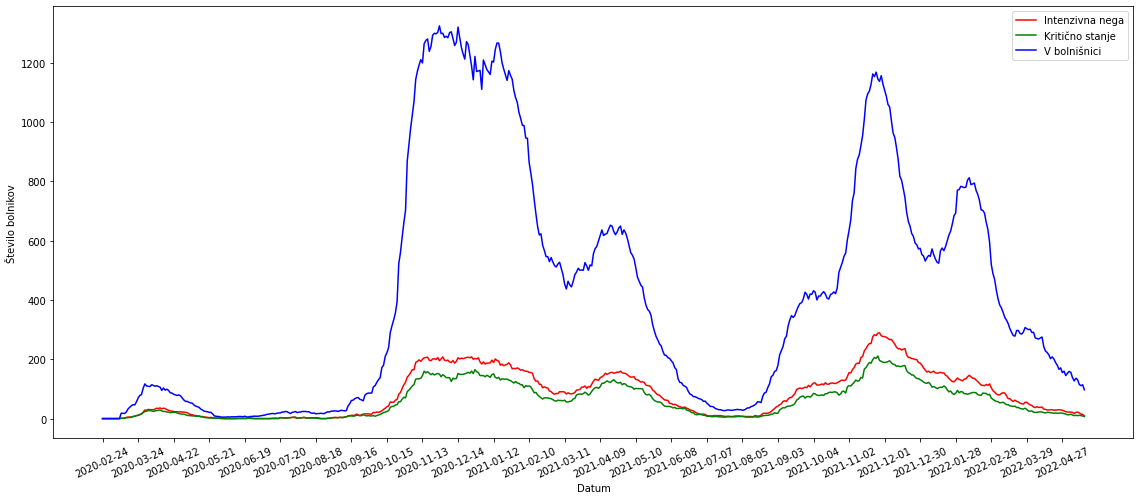

In [7]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
plt.xlabel("Datum")
plt.ylabel("Število bolnikov")
ax.plot(icu,  color="red", label='Intenzivna nega')
ax.plot(critical,  color="green", label='Kritično stanje')
ax.plot(in_hospital,  color="blue", label='V bolnišnici')
ax.set_xticks(new_dates_index)
ax.set_xticklabels(new_dates)
plt.xticks(rotation = 25)
plt.legend()
plt.show()

# 3. koliko jih je umrlo skozi čas (kdaj največ itd.)

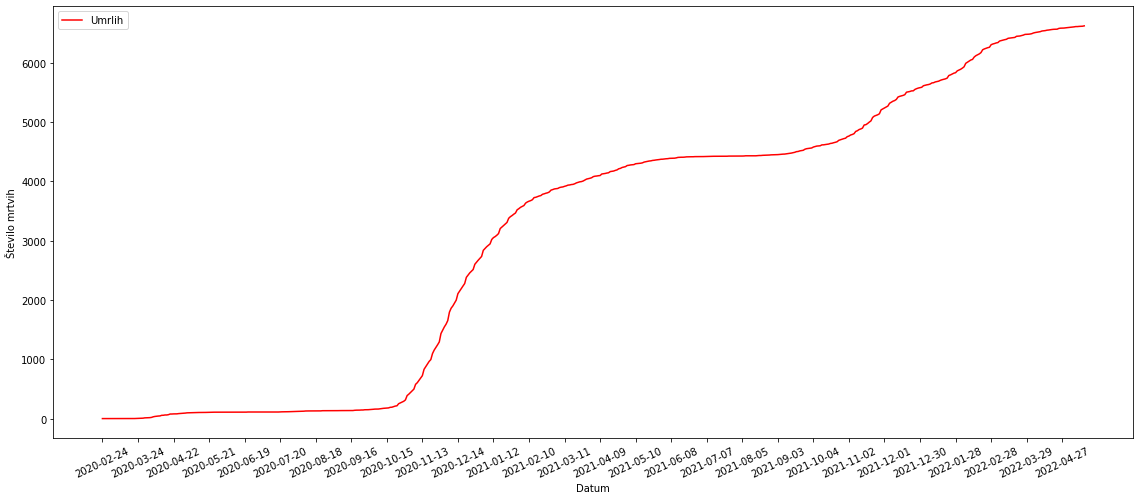

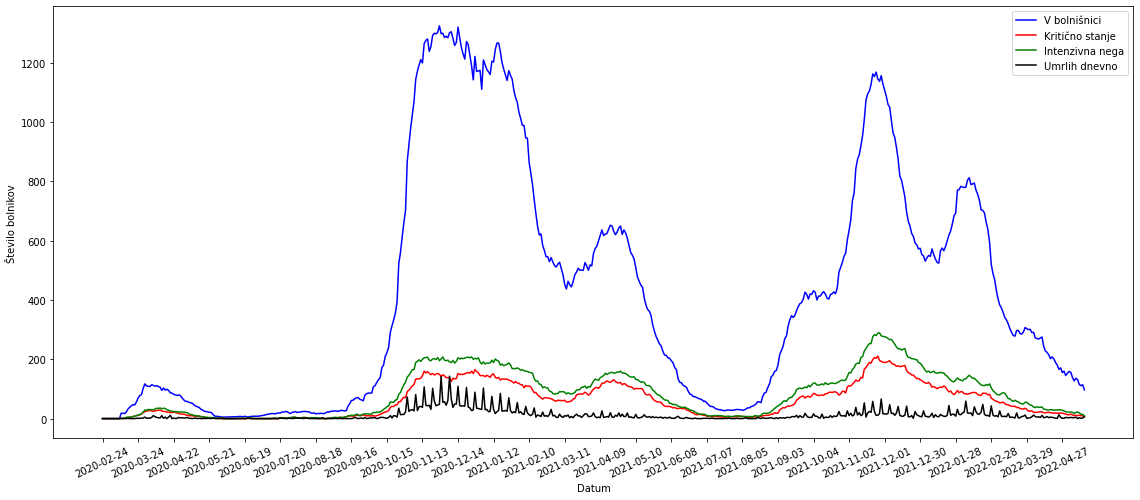

In [8]:

# how many people died
dead = []
for day in stats:
    # skip weekend
    cur_date = datetime.strptime(day["date"], '%Y-%m-%d')
    if cur_date.weekday() >= 5:
        continue

    dead.append(int(day["state.deceased.todate"]) if len(day["state.deceased.todate"]) else 0)

# make plot
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(dead, color="red", label="Umrlih")
ax.set_xticks(new_dates_index)
ax.set_xticklabels(new_dates)
plt.ylabel("Število mrtvih")
plt.xlabel("Datum")
plt.xticks(rotation = 25)
plt.legend()
plt.show()


# convert cumulative sum to daily sum of deaths
dead_daily = []
for i in range(len(dead)):
    if i == 0:
        dead_daily.append(dead[i])
    else:
        dead_daily.append(dead[i] - dead[i-1])

# make a plot with in hospital , critical, icu, daily death
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(in_hospital, color="blue", label="V bolnišnici")
ax.plot(critical, color="red", label="Kritično stanje")
ax.plot(icu, color="green", label="Intenzivna nega")
ax.plot(dead_daily, color="black", label="Umrlih dnevno")
ax.set_xticks(new_dates_index)
ax.set_xticklabels(new_dates)
plt.ylabel("Število bolnikov")
plt.xlabel("Datum")
plt.xticks(rotation = 25)
plt.legend()
plt.show()


**ODGOVOR**



# 4. koliko okužb glede na letni čas?

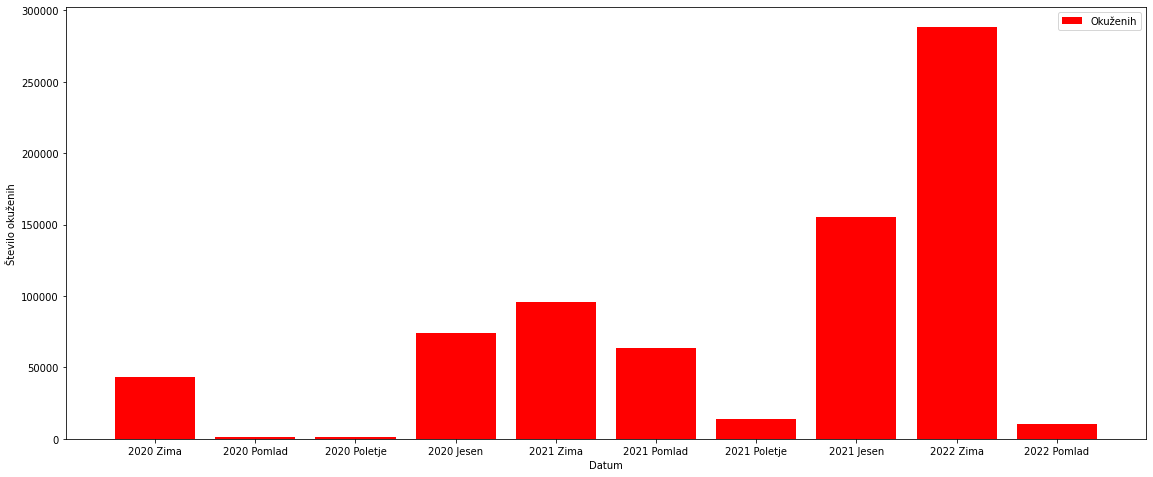

In [9]:
# Zima -> december, januar, februar
# Pomlad -> marec, april, maj
# Poletje -> junij, julij, avgust
# Jesen -> september, oktober, november

zima = {}
pomlad = {}
poletje = {}
jesen = {}
years = set()

for day in stats:
    cur_date = datetime.strptime(day["date"], '%Y-%m-%d')
    years.add(cur_date.year)
    if cur_date.month == 12 or cur_date.month == 1 or cur_date.month == 2:
        if cur_date.year not in zima:
            zima[cur_date.year] = 0
        zima[cur_date.year] += int(day["tests.positive"]) if len(day["tests.positive"]) else 0
    elif cur_date.month == 3 or cur_date.month == 4 or cur_date.month == 5:
        if cur_date.year not in pomlad:
            pomlad[cur_date.year] = 0
        pomlad[cur_date.year] += int(day["tests.positive"]) if len(day["tests.positive"]) else 0
    elif cur_date.month == 6 or cur_date.month == 7 or cur_date.month == 8:
        if cur_date.year not in poletje:
            poletje[cur_date.year] = 0
        poletje[cur_date.year] += int(day["tests.positive"]) if len(day["tests.positive"]) else 0
    elif cur_date.month == 9 or cur_date.month == 10 or cur_date.month == 11:
        if cur_date.year not in jesen:
            jesen[cur_date.year] = 0
        jesen[cur_date.year] += int(day["tests.positive"]) if len(day["tests.positive"]) else 0

letni_casi = []
imena = []

for year in sorted(list(years)):
    if year in zima:
        letni_casi.append(zima[year])
        imena.append(str(year) + " Zima")
    if year in pomlad:
        letni_casi.append(pomlad[year])
        imena.append(str(year) + " Pomlad")
    if year in poletje:
        letni_casi.append(poletje[year])
        imena.append(str(year) + " Poletje")
    if year in jesen:
        letni_casi.append(jesen[year])
        imena.append(str(year) + " Jesen")

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(imena, letni_casi, color="red", label="Okuženih")
plt.ylabel("Število okuženih")
plt.xlabel("Datum")
plt.legend()
plt.show()

# 5. presežene smrti po letih

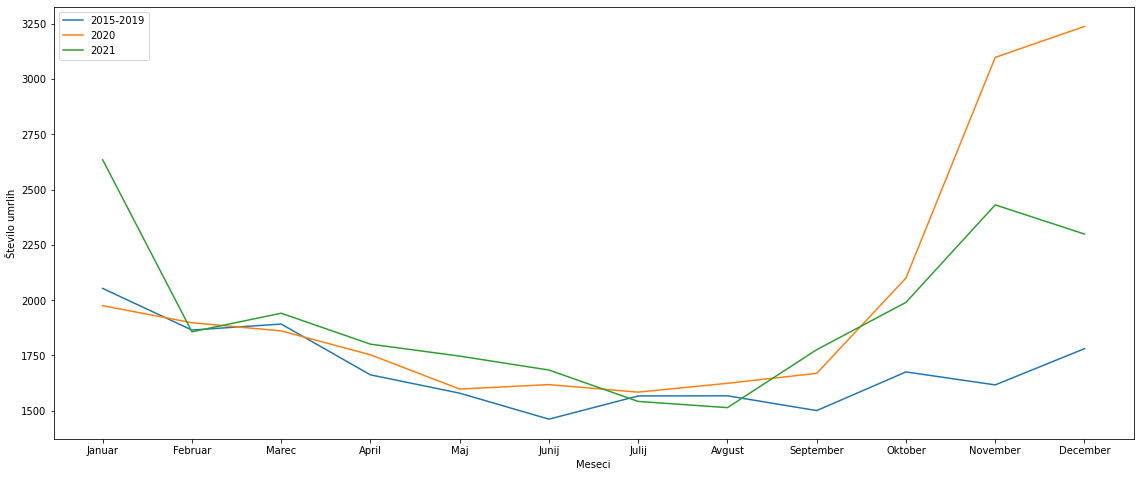

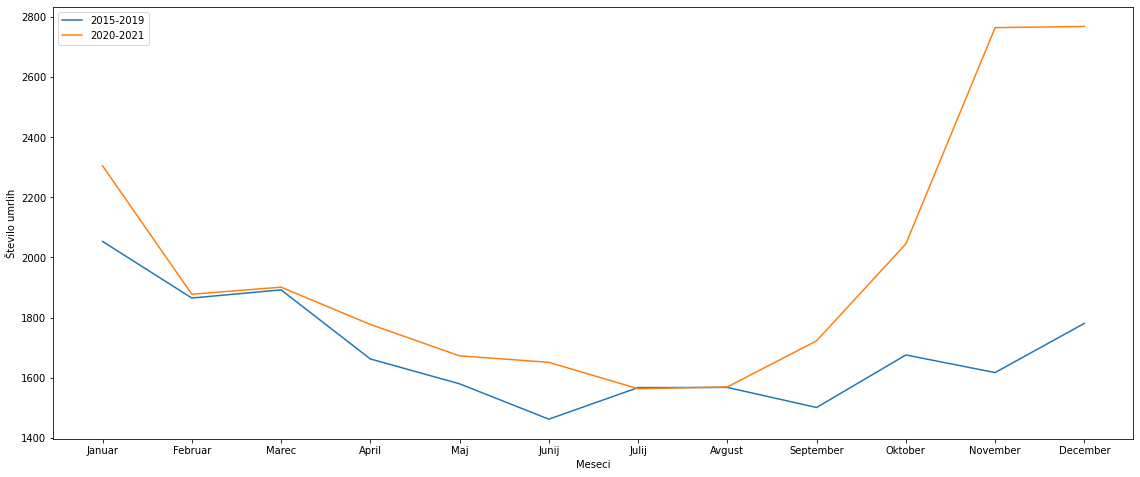

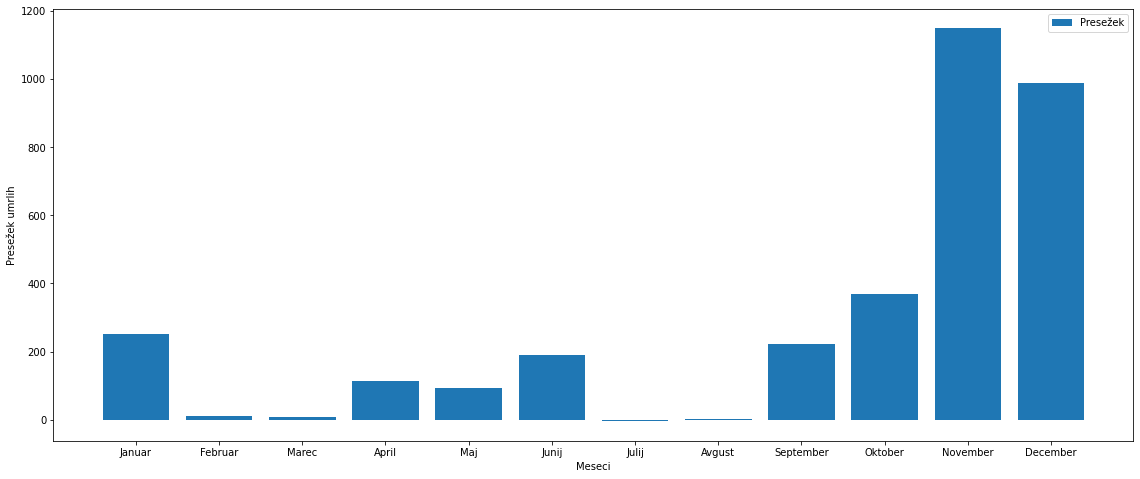

In [10]:
months = ["Januar", "Februar", "Marec", "April", "Maj", "Junij", "Julij", "Avgust", "September", "Oktober", "November", "December"]

smrti = {}
with open('podatki/smrti.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        month_name = row[0][:4]
        if month_name not in smrti:
            smrti[month_name] = []
        sum_mesec = sum(int(day) if day != "-" else 0 for day in row[1:])
        smrti[month_name].append(sum_mesec)
del smrti["2022"]

years = ["2015", "2016", "2017", "2018", "2019"]
smrti["2015-2019"] = [sum(smrti[year][month] for year in years) / len(years) for month in range(0, 12)]
years = ["2020", "2021"]
smrti["2020-2021"] = [sum(smrti[year][month] for year in years) / len(years) for month in range(0, 12)]

smrti["diff"] = [smrti["2020-2021"][month] - smrti["2015-2019"][month] for month in range(0, 12)]

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(smrti["2015-2019"], label="2015-2019")
ax.plot(smrti["2020"], label="2020")
ax.plot(smrti["2021"], label="2021")
ax.set_xticks([i for i in range(0, 12)])
ax.set_xticklabels(months)
plt.ylabel("Število umrlih")
plt.xlabel("Meseci")
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(smrti["2015-2019"], label="2015-2019")
ax.plot(smrti["2020-2021"], label="2020-2021")
ax.set_xticks([i for i in range(0, 12)])
ax.set_xticklabels(months)
plt.ylabel("Število umrlih")
plt.xlabel("Meseci")
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(months, smrti["diff"], label="Presežek")
plt.ylabel("Presežek umrlih")
plt.xlabel("Meseci")
plt.legend()
plt.show()

**ODGOVOR**

# 6. Obarvana slovenija

In [11]:
from IPython.display import SVG, display, Image
def show_svg(name):
    display(SVG(f"podatki/images/svgs/{name}.svg"))

def show_img():
    Image("podatki/images/result.gif")  

# show_svg()

# print(dict_municipality)

def calculate_color(cases, population):
    percent = (int(cases) / int(population)) * 100
    # convert percentage to a gradient color in 0.5 intervals
    return f"rgb({min(int(percent * 100), 255)}, {255 - min(int(percent * 100), 255)}, 0)"

images_paths = []


def generate_svg_for_day(data, file_name):
    #read input file
    fin = open("podatki/images/si.svg", "rt")
    #read file contents to string
    file_data = fin.read()
    #close the input file
    fin.close()
    #open the input file in write mode
    fin = open(f"podatki/images/svgs/{file_name}.svg", "wt")
    #overrite the input file with the resulting data
    fin.write(file_data)

    images_paths.append(f"podatki/images/svgs/{file_name}.svg")

    #close the file
    fin.close()
    for region in data:
        for city in data[region]:
            for dict_data in dict_municipality:
                if dict_data["id"] == city and dict_data["region"] == region:
                    dict_name = dict_data["name_alt"] or dict_data["name"]
                    name = dict_name.lower().title().replace("š", "s").replace("č", "c").replace("ž", "z").replace("Š", "S").replace("Č", "C").replace("Ž", "Z").replace("-", " ")
                    name = " ".join(name.split())
                    num = data[region][city]

                    #read input file
                    fin = open(f"podatki/images/svgs/{file_name}.svg", "rt")

                    #read file contents to string
                    file_data = fin.read()

                    #replace all occurrences of the required string
                    file_data = file_data.replace(f'name="{name}"', f'name="{name}" fill="{calculate_color(num, dict_data["population"])}"')

                    #close the input file
                    fin.close()

                    #open the input file in write mode
                    fin = open(f"podatki/images/svgs/{file_name}.svg", "wt")

                    #overrite the input file with the resulting data
                    fin.write(file_data)

                    #close the file
                    fin.close()

data = muni["2021-12-01"]
generate_svg_for_day(data, "test2")
data = muni["2020-12-01"]
generate_svg_for_day(data, "test")

pngs = []

# function convert svg to jpg
from cairosvg import svg2png
for img in images_paths:
    cairosvg.svg2png(url=img, write_to=img.replace(".svg", ".png").replace("svgs", "pngs"))
    pngs.append(img.replace(".svg", ".png").replace("svgs", "pngs"))

# convert svgs to gif
from PIL import Image as PILImage, ImageDraw
images = [PILImage.open(r) for r in pngs]
images[0].save("podatki/images/result.gif",
               save_all = True, append_images = images[1:],
               optimize = False, duration = 10)


OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7e

**ODGOVOR**

# 7. Virus v odpadnih vodah

**ODGOVOR**

# 8. Hospitaliziacije - status cepljenja in starost

**ODGOVOR**

# Zaključek

besedilo...